In [ ]:
# If you run this notebook on Google Colab, please uncomment this line
# !pip install bayesflow ssm-simulators

In [1]:
import os

if 'KERAS_BACKEND' not in os.environ:
    os.environ['KERAS_BACKEND'] = 'jax'

# Please Note: 
# you can also use CUDA-enabled Jax to supercharge your workflow with blazing speed.
# For this, please uncomment the code below to suppress the XLA autotuning warnings.

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import bayesflow as bf

from ssms.basic_simulators.simulator import simulator as ssm_sim

INFO:bayesflow:Using backend 'jax'


# A Minimal Bayesian Workflow for Cognitive Modeling with SSMS and BayesFlow

 In this tutorial, we demonstrate a [principled Bayesian workflow](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html) for developing and applying cognitive models with Amortized Bayesian Inference (ABI). We use Sequential Sampling Models (SSMs) to represent and simulate a cognitive process. The simulation is given by the [Sequential Sampling Model Simulators (SSMS)](https://lnccbrown.github.io/ssm-simulators/api/ssms/) package, the backbone for the [Hierarchical Sequential Sampling Model (HSSM) toolbox](https://lnccbrown.github.io/HSSM/). We use [BayesFlow](https://bayesflow.org)'s powerful generative neural networks and comprehensive diagnostics utilities to train on the simulated data, estimate model parameters, verify computational faithfulness, and obtain estimates on real data.

## Simulator

We start with the basic simulator from the HSSM toolbox. We start with the simplest simulator available: the classic drift-diffusion model (DDM) with 4 parameters:

* Drift rate ($v$),
* Boundary ($a$),
* Initial bias ($z$), and
* Non-decision time ($t$).

These are the parameters that we sample as priors (to be specified below) and used as inputs. For each sampled parameters, we specify `num_trials` for the simulation. The resulting collection of reaction times (RTs) and choices are our simulation outputs. These outputs are used as our dataset for training and validating the neural approximator.

In [29]:
def ddm_simulator(v: float, a: float, z: float, tau: float, num_trials: int = 100):
    """
    A simple wrapper of the standard Drift-Diffusion Model (DDM) simulator using the SSMS package. 
    It will simulate `num_trials` responses of synthetic participant with the provided parameters.

    Parameters
    ----------
    v : float, default: None
        User-defined drift rate.
    a : float, default: None
        User-defined decision boundary threshold.
    z : float, default: None
        User-defined initial decision bias.
    tau : float, default: None
        User-defined non-decision time (NDT).
    num_trials : int, default: 100
        Number of simulated trials for the synthetic participant.

    Returns
    -------
    A dictionary of the following simulated data of shape (num_samples, 1) each:
    - rts: reaction times
    - choices: Choice decision outcomes
    """

    # Directly simulate using SSMS
    ddm_sim = ssm_sim(model="ddm", theta=dict(v=v, a=a, z=z, t=tau), n_samples=num_trials)

    rts = ddm_sim['rts']
    choices = ddm_sim['choices']

    return dict(rts=rts, choices=choices)

In [30]:
# Test the simulator generating a single synthetic participant
sim = ddm_simulator(v=0.5, a=1.0, z=0.5, tau=0.7)
print(sim['rts'].shape)
print(sim['choices'].shape)

(100, 1)
(100, 1)


## Priors

Next, we will sample the DDM parameters from our simulator as priors from some distributions. Below, we specify the prior distributions:

\begin{equation}
v \sim \mathrm{Gamma}(2, 0.8), \; a \sim \mathrm{Gamma}(10, 0.2), \; z \sim \mathrm{Beta}(2, 2), \; t \sim \mathrm{Gamma}(1.5, 0.2).
\end{equation}

In [31]:
def prior(rng=None):
    """
    Defines the priors for all parameters in the standard DDM.

    Parameters
    ----------
    rng : np.random.RandomState, default: None
        Random number generator.

    Returns
    -------
    A dictionary of all standard DDM parameters:
    - v: drift rate
    - a: decision boundary threshold
    - z: initial decision bias
    - tau: non-decision time
    """
    if rng is None:
        rng = np.random.default_rng()

    drift = rng.gamma(2, 0.8)
    threshold = rng.gamma(10, 0.2)
    bias = rng.beta(3, 3)
    ndt = rng.gamma(1.5, 0.2)

    return dict(v=drift, a=threshold, z=bias, tau=ndt)

In [32]:
# We can inspect the sampled parameter dictionary
theta = prior()
theta

{'v': 0.5695249882715013,
 'a': 2.0489938825201115,
 'z': 0.27794640576467466,
 'tau': 0.5010394903284391}

## Putting everything together

After specifying the simulator and priors, we would wrap them together using BayesFlow's `make_simulator` function. Under the hood, BayesFlow unpacks the dictionary of samples from `priors` and uses them as inputs for the `ddm_simulator`. You can chain an arbitrary number of functions in the same manner.

In [33]:
simulator = bf.make_simulator([prior, ddm_simulator])

Once we have the `simulator`, we can specify a batch size and use it to generate samples, just like what we did from `ddm_simulator` itself.

In [34]:
batch_size = 10
draws = simulator.sample(batch_size)

The sample draws consists of both the simulator outputs from `ddm_simulator` and the prior samples from `priors`. Because we specified a batch size, the draws would have shapes `(batch_size, ...)`.

In [35]:
print(draws['v'].shape)
print(draws['tau'].shape)
print(draws['rts'].shape)
print(draws['choices'].shape)

(10, 1)
(10, 1)
(10, 100, 1)
(10, 100, 1)


## Prior Predictive Checks

To make sure that we are sampling the priors properly, BayesFlow has a pretty nice visual inspection in its `diagnostics` module that allows us to observe the samples directly as the respective sample distribution for each parameter.

In [36]:
prior_samples = simulator.simulators[0].sample(500)

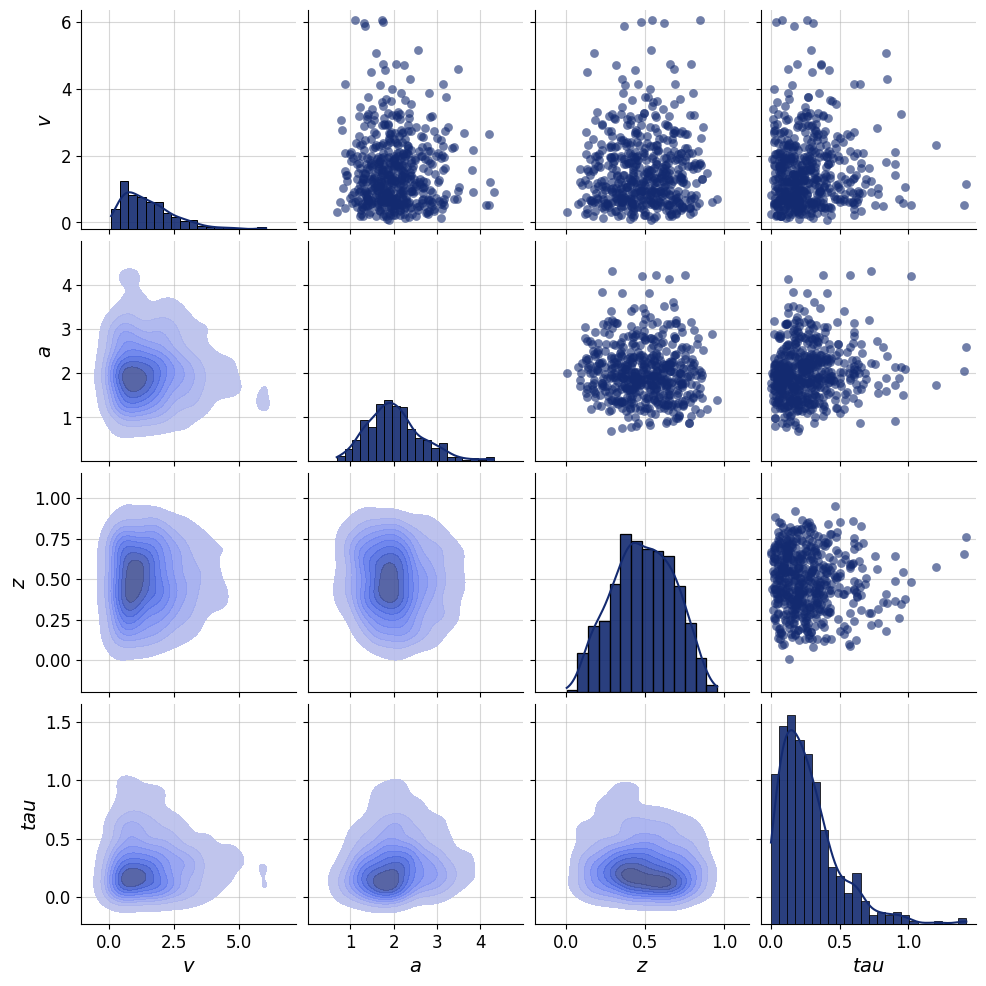

In [37]:
prior_grid = bf.diagnostics.plots.pairs_samples(samples=prior_samples, variable_names=[r'$v$', r'$a$', r'$z$', r'$tau$'])

Furthermore, to ensure that the simulator produces reliable results, we can also visualize the outputs from `simulator` samples by their individual draw.

In [38]:
n_rows = 2
n_cols = batch_size // n_rows

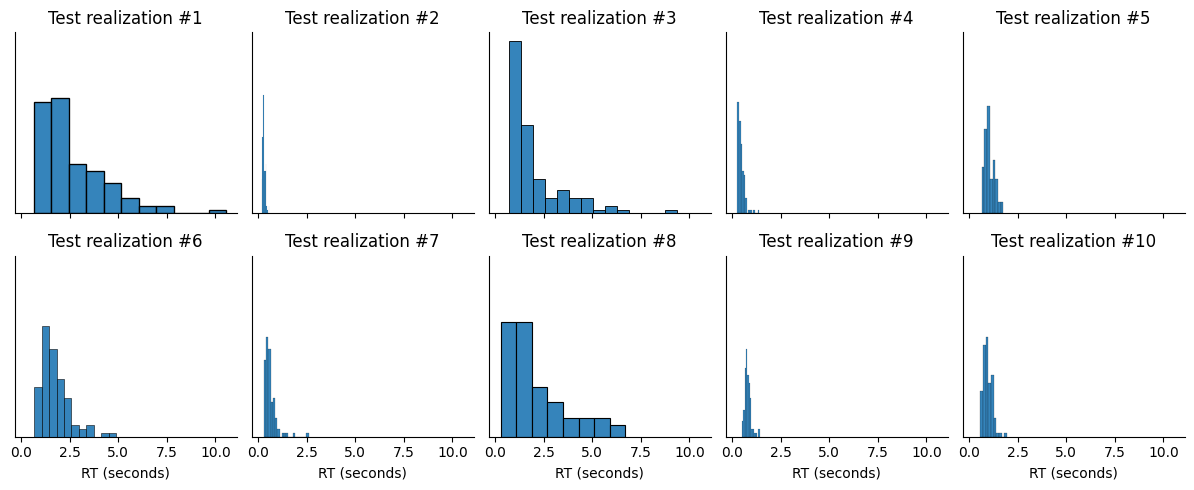

In [39]:
fig, axarr = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 5), sharey=True, sharex=True)

for i, ax in enumerate(axarr.flat):
    sns.histplot(data=draws['rts'][i], ax=ax, color="#132a70", legend=None, alpha=0.9)
    if i > n_cols - 1:
        ax.set_xlabel("RT (seconds)")
    ax.set_ylabel("")
    ax.set_yticks([])
    sns.despine(ax=ax)
    ax.set_title(f"Test realization #{i+1}")
fig.tight_layout()

## Adapter

To make sure that the simulated data and priors all friendly to the neural approximator, we use BayesFlow's `Adapter` to transform the data into summary variables and inference variables.

In a nutshell, from the perspective of the neural estimator:

* **Summary variables** are simulated data, and
* **Inference variables** are the parameters.

In [40]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype('float64', 'float32')
    .concatenate(['v', 'a', 'z', 'tau'], into="inference_variables")
    .constrain("inference_variables", lower=0)
    .concatenate(['rts', 'choices'], into="summary_variables")
)

Here is what the individual elements in `adapter` means:

* `.convert_dtype()` converts all samples to a data type that the neural estimator likes. Typically, this is `float32`.
* `.concatenate()` bundles the sampled parameters together as `inference_variables`, and the simulated response times and choices as `summary_variables`.
* `.constrain()` informs the networks that the parameter has bounds, making the learning task easier.

Below, we can visualize the `adapter` workflow to make the data preprocessing steps transparent.

In [41]:
adapter

Adapter([0: ConvertDType -> 1: Concatenate(['v', 'a', 'z', 'tau'] -> 'inference_variables') -> 2: Constrain -> 3: Concatenate(['rts', 'choices'] -> 'summary_variables')])

We can inspect the transformed data after wrapping the simulation in the adapter to process.

In [42]:
adapted_draws = adapter(simulator.sample(3))

In [43]:
# This step makes sure that the samples are bundled properly as summary variables and inference variables
print("Shape of summary variables", adapted_draws['summary_variables'].shape)
print("Shape of inference variables", adapted_draws['inference_variables'].shape)

Shape of summary variables (3, 100, 2)
Shape of inference variables (3, 4)


## Neural estimator

The neural estimator is essentially a two-stage generative neural network consisting of a **summary network** and an **inference network**.

* **Summary network** takes the simulated data (*summary variables*) directly as inputs, and compress it into some latent summary statistics,
* **Inference network** takes the summary statistics as inputs, and infers the parameters (*inference variables*) from them.

### Summary Network

Since our likelihood generates data exchangeably, we need to respect the associated permutation invariance. The latter implies that the probability distribution of a sequence of observations remains the same regardless of the order in which the observations appear. For that, we will use a tiny `SetTransformer` network that will be fast to training on a CPU. If you are interested, you can find more detail about Set Transformer in [this paper](https://arxiv.org/abs/1810.00825).

This network will take (at least) 3D tensors of shape `(batch_size, num_obs, D)` and reduce them to 2D tensors of shape `(batch_size, summary_dim)`, where `summary_dim` is a hyperparameter to be set by the user (you). Heuristically, this number should not be lower than the number of parameters in a model. Below, we create a permutation-invariant transformer network with default `summary_dim = 16`:

In [44]:
# Alternatively, you can also use DeepSet
summary_net = bf.networks.SetTransformer(embed_dims=(32, 32), mlp_widths=(32, 32))

### Inference Network

To actually approximate the posterior distribution, we need to define a generative neural network. Here we choose the all time favorite `CouplingFlow` that realizes a simple normalizing flow.

In [45]:
inference_net = bf.networks.CouplingFlow(depth=2, transform="spline", permutation="orthogonal")

## Workflow

BayesFlow makes everything easier by wrapping the entire amortization process into workflow objects. Here, we can simply use a `BasicWorkflow` object that bring together the simulator, the adapter, the summary network, and the inference network. We also instuct the workflow not to standardize any of the variable, as we are taking care of the parameters in the adapter and our data (i.e., summary conditions) is on a reasonable scale.

In [46]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net,
    standardize=None
)

## Training

Using the `BasicWorkflow` object, we can generate training data and validation data for training the neural estimator. Typically, you will generate much more and possibly traing online (i.e., using on-demand simulation).

In [47]:
training_data = workflow.simulate(5000)
validation_data = workflow.simulate(300)

In [48]:
history = workflow.fit_offline(
    data=training_data,
    epochs=20,
    batch_size=32,
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 309ms/step - loss: 5.4532 - val_loss: 4.7128
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.0095 - val_loss: 3.4720
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.2753 - val_loss: 3.1306
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5386 - val_loss: 2.2903
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9824 - val_loss: 1.9182
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6310 - val_loss: 1.5454
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4150 - val_loss: 1.0615
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1616 - val_loss: 0.9472
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9821 - val_loss: 0.7184
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8468 - val_loss: 0.5990
Epoch 11/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6531 - val_loss: 0.3482
Epoch 12/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/s

## Diagnostics

The `BasicWorkflow` object also gather all the diagnostics functionality that BayesFlow has to offer.

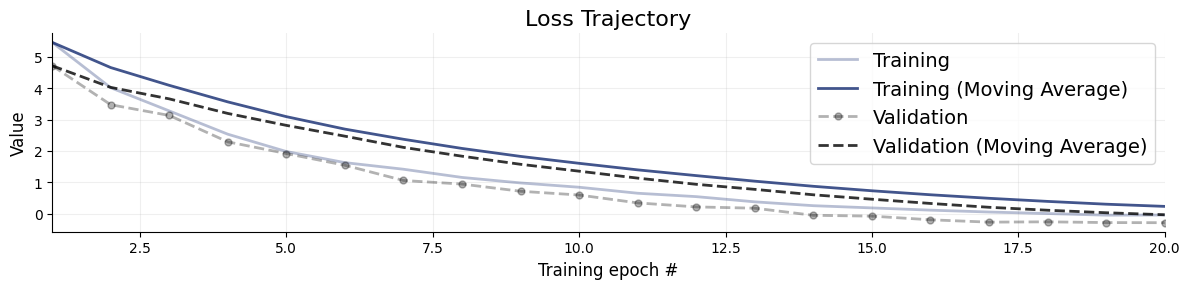

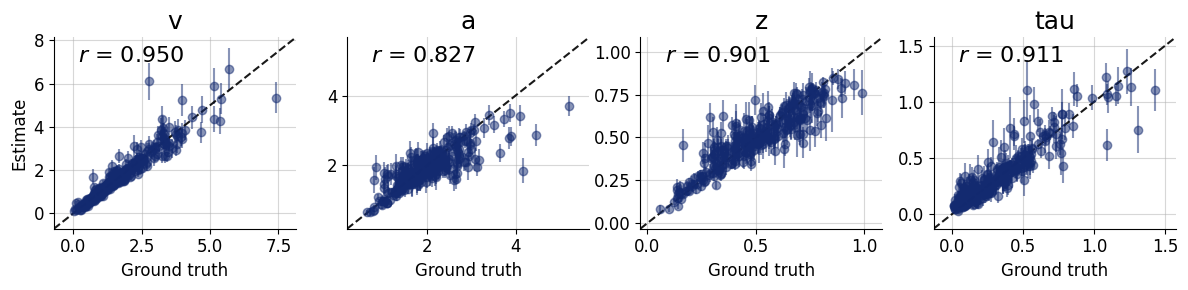

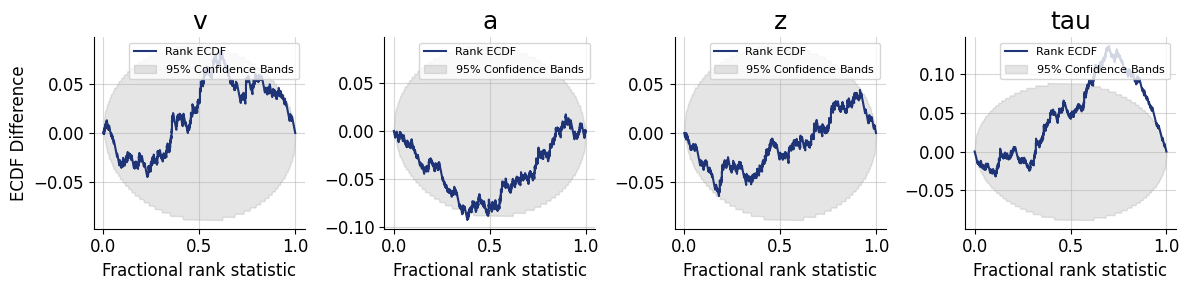

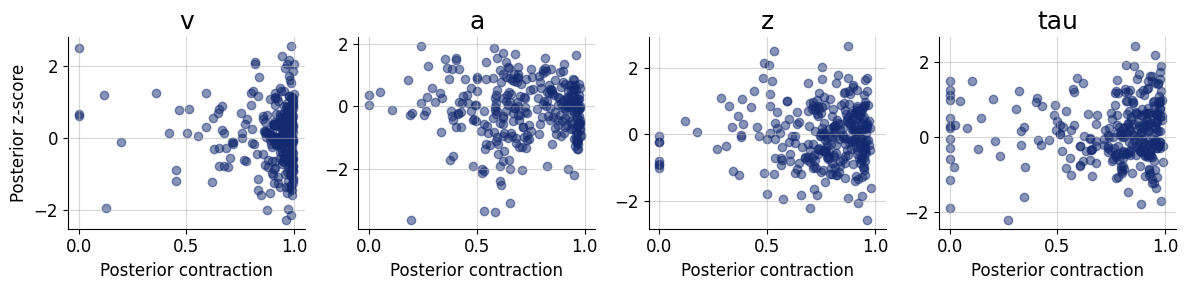

In [49]:
figures = workflow.plot_default_diagnostics(
    test_data=validation_data,
    loss_kwargs={"figsize": (12, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (12, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (12, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (12, 3), "label_fontsize": 12}    
)

*Here, we describe what each of these plots means. From top to bottom:

1) **Loss Trajectory** records the training and validation losses per epoch for the neural estimator.
2) **Parameter Recovery** gives us a sense of whether the distribution from the generated posterior samples from the neural estimator is in agreement with the ground truth from the simulated dataset. This indicates the *global inferential accuracy* of the neural estimator.
3) **Rank ECDF** plots the expected cumulative distribution function (ECDF) for the rank statistics of the parameter samples. For a well-calibrated neural estimator, this function should fall entirely within the 95\% confidence bands for all parameters. For more detail, please take a look at [this paper about simulation-based calibration (SBC)](https://arxiv.org/abs/2103.10522).
4) **$z$-score contraction** does a similar job as parameter recovery in a sense that it tells us how well the posterior estimation is from the true parameter. For more detail, please take a look at [this page](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html)

You can also easily get numerical versions for these diagnostics:

In [50]:
table = workflow.compute_default_diagnostics(test_data=validation_data)
table

,v,a,z,tau
NRMSE,0.071316,0.115616,0.136023,0.121197
Posterior Contraction,0.952308,0.720935,0.811686,0.841667
Calibration Error,0.063333,0.020351,0.036667,0.084035


**Congrats!** Now you have learned about the workflow from simulation to estimation through the inter-working between the SSM Simulator and BayesFlow!

## Making the Simulator More Realistic

In real behavioral data, some responses may not reflect the cognitive process of interest, but instead arise from lapses, distractions, or accidental key presses. These are often referred to as **contaminant trials**. To mimic such situations in simulations, it is common to add a small proportion of random responses with uniformly distributed reaction times and random choices.

In [3]:
def extended_ddm_simulator(
    v: float, 
    a: float, 
    z: float, 
    tau: float, 
    num_trials: int = 100, 
    contam_prop: float = 0.05,
):
    """
    A simple wrapper of the standard Drift-Diffusion Model (DDM) simulator using the SSMS package. 
    It will simulate `num_trials` responses of synthetic participant with the provided parameters,
    including a proportion of contaminant trials with random RTs and choices.

    Parameters
    ----------
    v : float
        User-defined drift rate.
    a : float
        User-defined decision boundary threshold.
    z : float
        User-defined initial decision bias.
    tau : float
        User-defined non-decision time (NDT).
    num_trials : int, default: 100
        Number of simulated trials for the synthetic participant.
    contam_prop : float, default: 0.05
        Proportion of contaminant trials (random response trials).

    Returns
    -------
    A dictionary of the following simulated data of shape (num_samples, 1) each:
    - rts: reaction times
    - choices: Choice decision outcomes
    """

    # Simulate standard DDM trials
    ddm_sim = ssm_sim(model="ddm", theta=dict(v=v, a=a, z=z, t=tau), n_samples=num_trials)
    rts = ddm_sim['rts']
    choices = ddm_sim['choices']

    # Add contaminants
    n_contam = int(np.round(num_trials * contam_prop))
    if n_contam > 0:
        contam_idx = np.random.choice(num_trials, size=n_contam, replace=False)
        rts[contam_idx, 0] = np.random.uniform(0, 20, size=n_contam)
        choices[contam_idx, 0] = np.random.randint(0, 2, size=n_contam)

    return dict(rts=rts, choices=choices)

In [52]:
simulator = bf.make_simulator([prior, extended_ddm_simulator])

### New Prior Predictive Check

Let's inspect the contaminated data visually.

In [53]:
draws = simulator.sample(30)

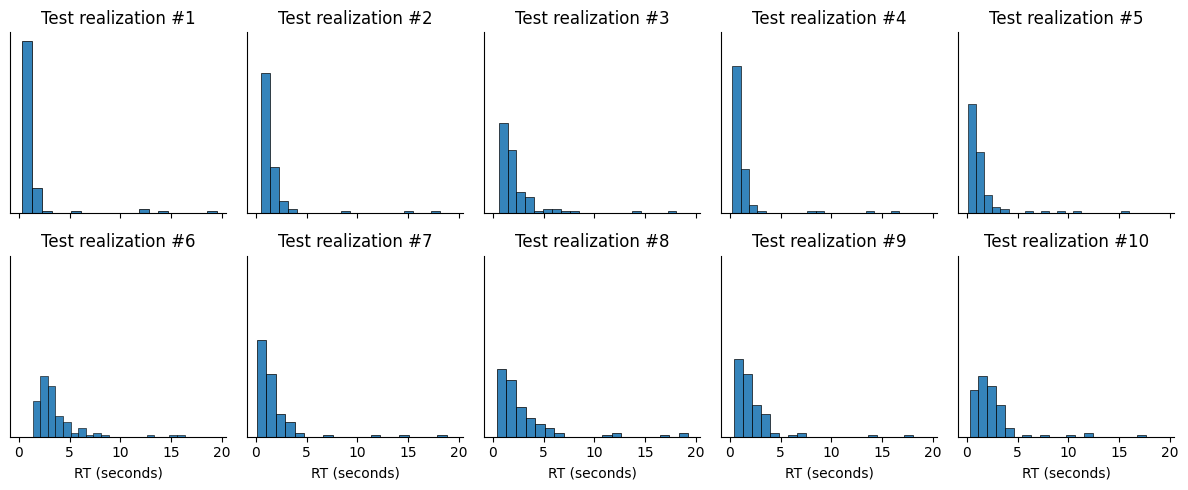

In [54]:
fig, axarr = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 5), sharey=True, sharex=True)

for i, ax in enumerate(axarr.flat):
    sns.histplot(data=draws['rts'][i], ax=ax, color="#132a70", legend=None, alpha=0.9)
    if i > n_cols - 1:
        ax.set_xlabel("RT (seconds)")
    ax.set_ylabel("")
    ax.set_yticks([])
    sns.despine(ax=ax)
    ax.set_title(f"Test realization #{i+1}")
fig.tight_layout()

### Inference on Contaminated Data

Recent work by our team has shown that amortized methods are particularly vulnerable to such misspecification. Inference networks trained on clean data can produce systematically biased estimates when exposed to contaminated data. Let's demonstrate this below.

In [55]:
contaminated_test_data = simulator.sample(300)

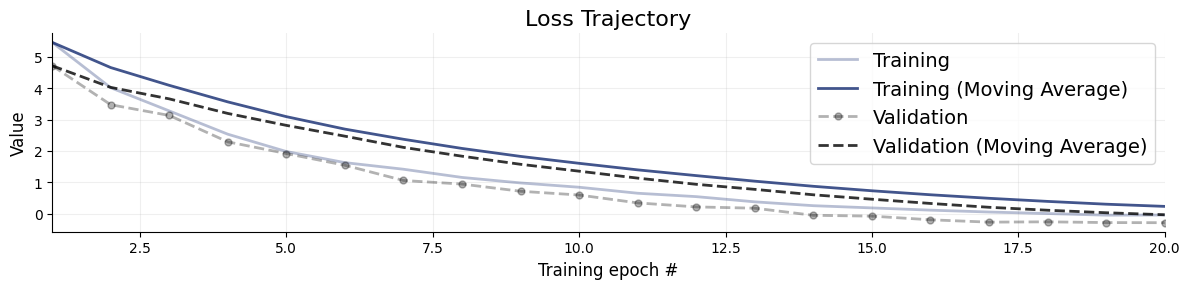

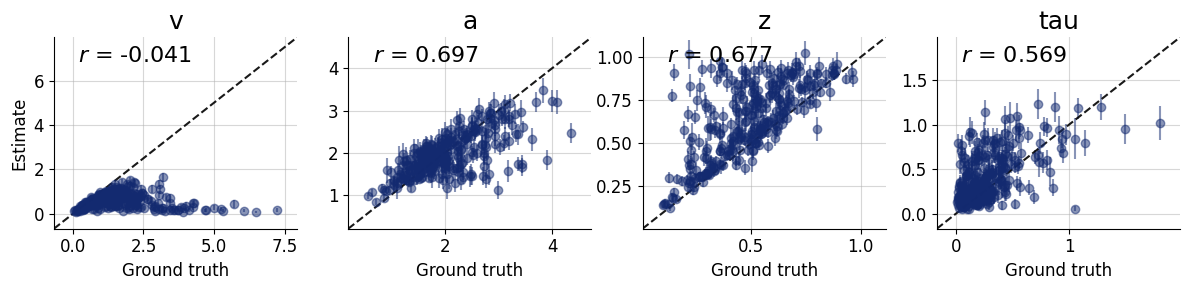

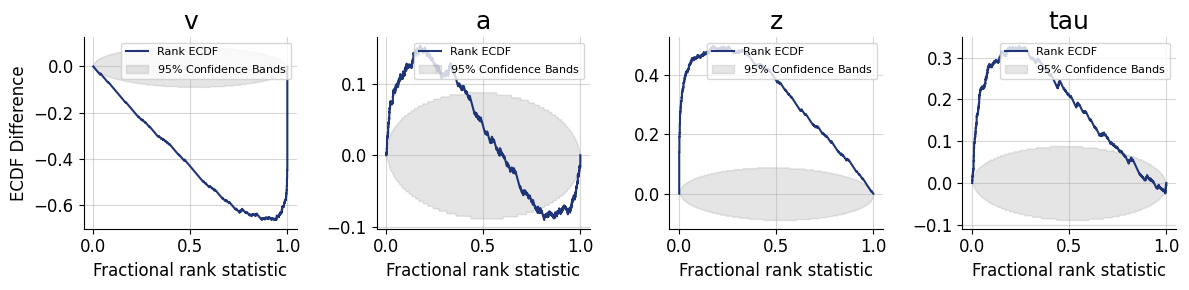

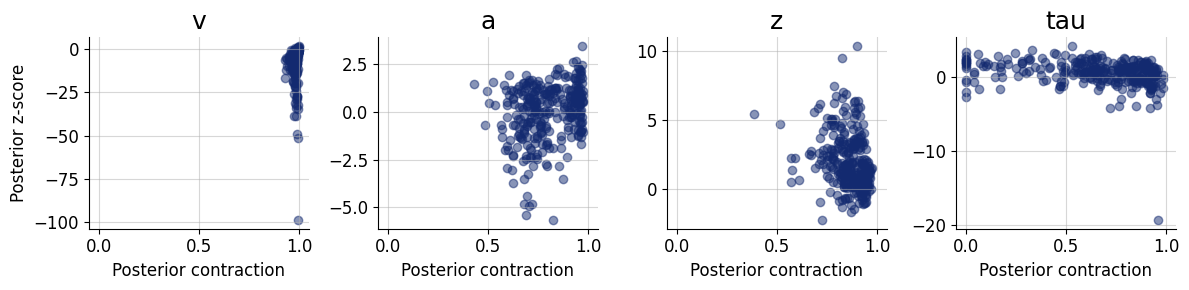

In [56]:
figures = workflow.plot_default_diagnostics(
    test_data=contaminated_test_data,
    loss_kwargs={"figsize": (12, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (12, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (12, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (12, 3), "label_fontsize": 12}    
)

Not cool. The estimates are all over the place. Still, we need to be careful when interpreting these results, as we don't know how the "true" posterior under the misspecified model looks like (which is our ultimate goal). Generally speaking, there are three possible inference targets:

- **Target 1**: The analytic (true) posterior $p(\theta \mid y_{\text{obs}}) \propto p(y_{\text{obs}} \mid \theta) \, p(\theta)$ of the assumed probabilistic model given the observed data $y_{\text{\text{obs}}}$. 

- **Target 2**: A posterior $p(\theta \mid \tilde{y}_{\text{obs}}) \propto p(\tilde{y}_{\text{obs}} \mid \theta) \, p(\theta)$ of the assumed probabilistic model given *adjusted data* $\tilde{y}_{\text{obs}}$. 

- **Target 3**: A posterior $\tilde{p}(\theta \mid y_{\text{obs}}) \propto p(y_{\text{obs}} \mid \theta) \, \tilde{p}(\theta)$ from an *adjusted prior* $\tilde{p}(\theta)$ given the observed data $y_{\text{obs}}$.

If we have a good idea of what the corruption process is, we should try to model it explicitly, as we will do here. Otherwise, more sophisticated techniques can be applied, depending on which target we are after.

### Training on Contaminated Data

In [57]:
# Use the same setup as above
summary_net = bf.networks.SetTransformer(embed_dims=(32, 32), mlp_widths=(32, 32))
inference_net = bf.networks.CouplingFlow(depth=2, transform="spline", permutation="orthogonal")

# Package as a workflow
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net,
    standardize=None
)

In [58]:
contaminated_training_data = workflow.simulate(5000)

In [59]:
history = workflow.fit_offline(
    data=contaminated_training_data,
    epochs=20,
    batch_size=32,
    validation_data=contaminated_test_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 85s 330ms/step - loss: 5.2537 - val_loss: 4.6617
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6336 - val_loss: 3.6795
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0439 - val_loss: 3.6097
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.6577 - val_loss: 2.5442
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1648 - val_loss: 2.0517
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8261 - val_loss: 1.6938
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5330 - val_loss: 1.4187
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3952 - val_loss: 1.3512
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2415 - val_loss: 0.8979
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0363 - val_loss: 0.7976
Epoch 11/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8972 - val_loss: 0.8374
Epoch 12/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/s

### In Silico Validation

Let's confirm that the contamination-aware network exhibits acceptable performance in the small world.

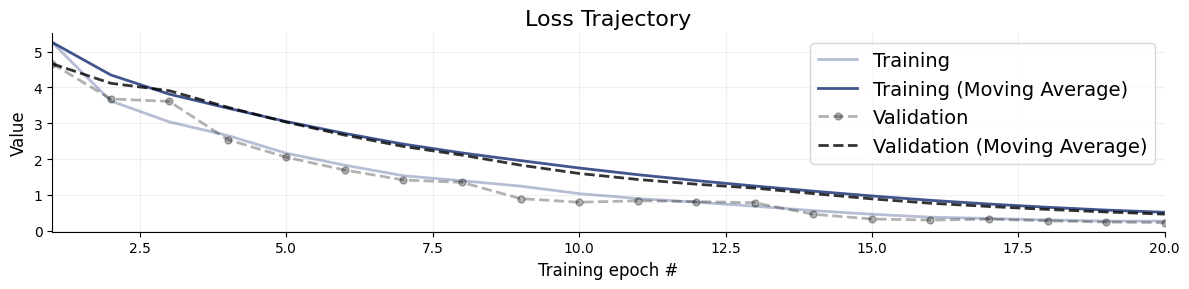

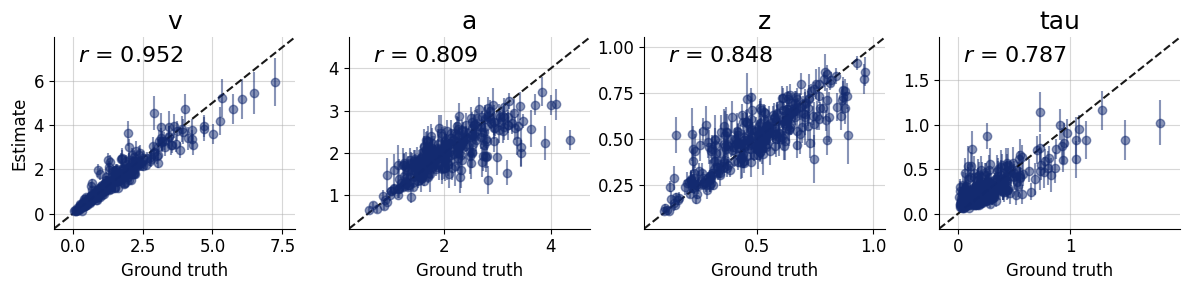

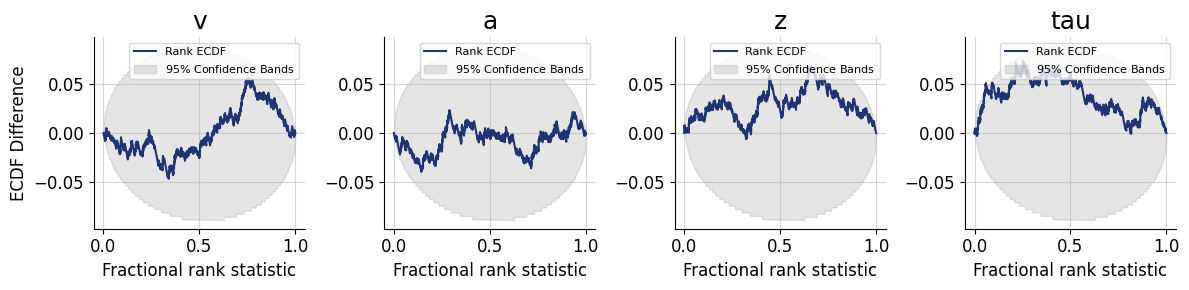

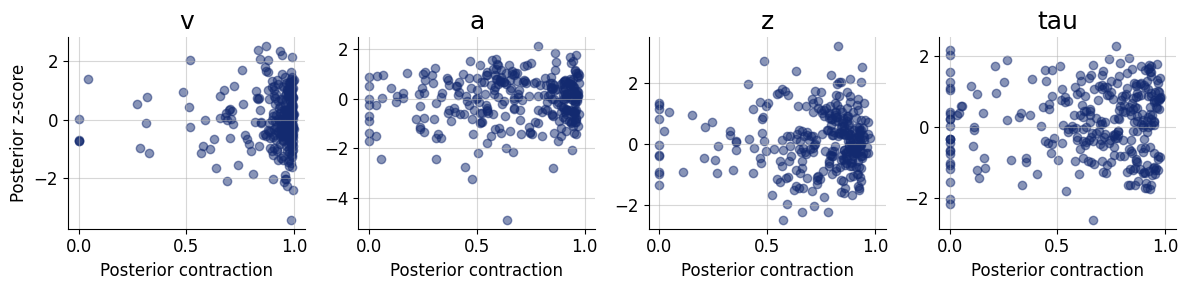

In [60]:
figures = workflow.plot_default_diagnostics(
    test_data=contaminated_test_data,
    loss_kwargs={"figsize": (12, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (12, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (12, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (12, 3), "label_fontsize": 12}    
)

Note, that we could have also just fine-tuned the first neural estimator (you are encouraged to try this as an exercise).

### Inference on Real Data

Finally, let's perform inference on 5 external data sets that will masquarade as real data. The point here is merely to demonstrate differences in format between real and simulated data, as real data does not always come nicely formatted as N-D arrays and some wrangling is needed to make it neural-network friendly. Let us first load the data:

In [ ]:
df = pd.read_csv("../data/simple_data.csv", sep=',', header=0)

df.head()

,ID,RT,Choice
0,1,1493,1
1,1,2262,1
2,1,2351,1
3,1,1933,1
4,1,2120,1


What do you obsevre?

In [ ]:
### Mini exercise 1: Your processing steps here

data_for_bf = {
    "rts": None,
    "choices": None
}

In [ ]:
# Once we are here, we can obtain an arbitrary number of samples from the trained network
sample_dict = workflow.sample(conditions=data_for_bf, num_samples=1000)

### Mini exercise 2: explore samples

Of course, to complete the Bayesian workflow, you would also need to perform two types of checks, asking slightly different questions:
1. **Posterior retrodictive checks**: Can my model *reproduce* the data used to estimate the parameters?

2. **Posterior predictive checks**: Can my model *predict* new data not used to estimate the parameters?

You are highly encouraged to think about how you would answer these questions and propose a tentative implementation.

## **Exercise 1**: Estimating the Contaminant Fraction as a Further Parameters

Your goal in this exercise is to turn the `contam_prop` into a parameter that you estimate along with the core DDM parameters. This is not uncommon, as "noise parameters" can carry a lot of information (e.g., think about the $\sigma$ parameter in simple regression). To do so, you would need to:
1. Define a proper prior over `contam_prop`.
2. Adjust the adapter the consider `contam_prop` along with the other parameters as `inference_variables`
3. Train a new network that now estimates 5 parameters
4. Evaluate its performance on test simulations. 

What can you observe? To find out, let us walk through this exercise step by step:

#### **Step 1**: define a new set of prior

First, you would need to make an assumption about what distribution `contam_prop` follows. Does `contam_prop` have any bounds as constraints? What common distributions satisfy these constraints?

In [ ]:
def prior_with_noise_parameter(rng=None):
    """
    Defines the priors for all parameters in the standard DDM.

    Parameters
    ----------
    rng : np.random.RandomState, default: None
        Random number generator.

    Returns
    -------
    A dictionary of all standard DDM parameters:
    - v: drift rate
    - (What other parameters do you need?)
    """

    if rng is None:
        rng = np.random.default_rng()

    drift = rng.gamma(2, 0.8)

    ### Your code here (~4 lines)

    # Don't forget to update the returned dict.
    # Make sure that your key conventions stay consistent.
    return dict(v=drift)

Now, update `make_simulator()` to include this new set of priors.

In [ ]:
### Your code here
simulator = None

For best practice, always perform prior checks to make sure that you are getting the desired prior distributions and behaviors.

In [ ]:
### Your code here
prior_samples = None
prior_grid = None

In [ ]:
# If you want, you can also visualize simulated outputs and see if the priors produce what you desire.
draws = None

### Your code here (~10 lines)
figures = None

#### **Step 2**: Update the adapter

In [ ]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype('float64', 'float32')
    .concatenate(['rts', 'choices'], into="summary_variables")
    # Your code here (2 lines)
)

#### **Step 3**: Train a new network

We can use the same setup as before. 

Alternatively, you can also experiment with `DeepSet`. If you do so, specify a good `summary_dim`. Something else to consider: does one summary network perform better than the other?

In [24]:
### Your code here
summary_net = bf.networks.SetTransformer(embed_dims=(32, 32), mlp_widths=(32, 32))
inference_net = bf.networks.CouplingFlow(depth=2, transform="spline", permutation="orthogonal")

# Package as a workflow
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net,
    standardize=None
)

In [ ]:
# Optionally, you can re-simulate the training and test data
# contaminated_train_data = workflow.simulate(5000)
# contaminated_test_data = workflow.simulate(300)

# Now re-train
### Your code here
history = None

#### **Step 4**: Validation

Finally, you can evaluate the performance of this new estimator using diagnostics.

In [ ]:
figures = workflow.plot_default_diagnostics(
    test_data=contaminated_test_data,
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}    
)

## **Exercise 2**: Extending the Model with More Conditions

Most DDM applications typically feature at least two experimental conditions. Accordingly, some parameters are allowed to vary between conditions, as one might hypothesize that differences between the conditions map onto differences between the parameters. Your goal in this exercise is to extend your DDM simulator with the capability to simulate synthetic participants undergoing two conditions. Concretely, you would need to:
1. Decide which parameters vary between the conditions and which are shared. I recommend starting with the drift rate, but you are free to test other variants.
2. Modify the prior to include the additional parameters (e.g., two drift rates).
3. Modify the simulator to accept the additional parameters and return three arrays (i.e., response times, choices, condition indicators). I suggest writing a separate function that calls the existing function twice, determining which parameters go where. You also need to decide how to handle the `num_trials` parameter (e.g., divide by two for each condition?).
4. Train and evaluate a new network. What do you observe?

In [ ]:
### Your code here. Try replicating the workflow as inspired by Exercise 1.